In [1]:
cd games

/Users/eduardodaroza/intro_dsi/capstone/Capstone/games


Loaded chess data in /src/dataloading.py to assemble combined.pgn

# Chess Prediction and Recommendation


#### A Capstone Project by Eduardo Daroza - Galvanize Data Science Immersive

*using CRISP - DM (Cross Industry Standard Process for Data Mining)


1. Business Understanding
---

This initial phase focuses on understanding the project objectives and requirements from a business perspective, and then converting this knowledge into a data mining problem definition, and a preliminary plan designed to achieve the objectives. A decision model, especially one built using the Decision Model and Notation standard can be used.


In chess, prediction of your opponents opening choice prior to the game provides a competitive advantage especially if a player has time to prepare some counter strategies.  Statistically studies have shown that playing white provides a small but measurable advantage in practive since white has the first move and may general has more influence in the opening battle.  

This capstone project will use chess data freely available on the web to aid in opening prediction to aid in the pre-game preparation for a chess player.  The goal will be train an ensemble model to first predict likely opening White moves based a data set of two million games and then to recommend those openings moves which should provide a better likelihood probability of success based on your opponents prior history and that of the likelihood of success of the opening in the dataset.  I will be breaking up the problem into two parts. 

i: First predict the three most likely moves to be made by the opponent.

ii: Second based on the data which responses provide the likelihood of success and to estimate the probability of success for those responses.

The user interface will be presented online on Elastic Beanstalk web use flask and a NoSQL db such as mongodb or Dynamodb to store the games for retrieval.

If time allows, I will explore chess style based on openings to try to provide categories of players and provide an interface for the user to practice the opening recommendations using stockfish open source engine.


2. Data Understanding
---
The data understanding phase starts with an initial data collection and proceeds with activities in order to get familiar with the data, to identify data quality problems, to discover first insights into the data, or to detect interesting subsets to form hypotheses for hidden information.


The web has several chess datasets consisting of millions of historical games.  Chess games are stored in a PGN (portable game notation) file format which is ascii readable and provides the game as well as metadata including the players, ratings, date, and result. 

My first dataset was obtained from http://www.top-5000.nl/pgn.htm as the 2.2 millionbase consisting of over 2 million games.  After some initial data exploration I found some of my own games, however more than 40% of the meta data was incomplete include opening information.  Attempts to scrape the missing data where resource intensive and error prone so I was able to find an alternative data set which had much better data fidelity.

3. Data Preparation
---
The data preparation phase covers all activities to construct the final dataset (data that will be fed into the modeling tool(s)) from the initial raw data. Data preparation tasks are likely to be performed multiple times, and not in any prescribed order. Tasks include table, record, and attribute selection as well as transformation and cleaning of data for modeling tools.

I used pandas for much of my initial EDA with a shard of 40,000 games and built my Minimal Viable product.  Below I have included some of the observations I made during the data exploration phase and the subsequent data cleaning and feature engineering used prior to the modeling phase. There is a seperate dataloading.py in my github repo which has some code used to combine the seperate pgns and some webscraping functions.



In [2]:
import sys  

reload(sys)  
sys.setdefaultencoding('utf8')
from __future__ import unicode_literals

game={}
games = []

pgn_file="combined.pgn"

with open(pgn_file,'r') as datafile:
    for line in datafile:
        line = line.decode('latin-1').encode("utf-8")       
        if line.startswith('['):
            tag,value=line[1:-1].split(' ',1)
            game[str(tag).lower()]=value.replace("]","").strip('"').encode('ascii', 'ignore')
        elif line.startswith('1.'):
            #only read first line: could add more readlines until a space
            game['moves']=line.encode('ascii', 'ignore')
            games.append(game)
            game = {}

In [3]:
df = pd.DataFrame(games) 

Ran into some encoding/unicode issues preventing loading so added decode('latin-l') due to some special character in the file.  And '"\r' was being appended during the dataloading so addressed this in data cleaning.

In [4]:
df.head(1)

,black,blackelo,date,eco,event,eventdate,fen,moves,result,round,setup,site,white,whiteelo
0,"Kosteniuk, Alexandra""\r","2554""\r","2016.02.29""\r","A05""\r","IMSA Blitz w 2016""\r","2016.02.28""\r",NaN,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,"0-1""\r","15.5""\r",NaN,"Huai'an CHN""\r","Harika, Dronavalli""\r","2511""\r"


In [5]:
df[df['fen'].isnull()==False]

,black,blackelo,date,eco,event,eventdate,fen,moves,result,round,setup,site,white,whiteelo
1114192,"Jurkovic, Hrvoje""\r","2426""\r","2006.??.??""\r","B22""\r","2. Bundesliga Mitte 2005/06 rounds 3-5""\r","2006.02.03""\r",rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,1...c5 2.c3 Nf6 3.e5 Nd5 4.d4 cxd4 5.Nf3 Nc6 6...,"0-1""\r","6.3""\r","1""\r","AUT""\r","Jeric, Simon""\r","2328""\r"


In [36]:
#garbage = test.pop('blackteam')
#garbage = test.pop('blacktitle')
#garbage = test.pop('whiteteam')
#garbage = test.pop('whitetitle')
#garbage = df.pop('eventdate')
#garbage = df.pop('eventtype')
##garbage = df.pop('site')
#garbage = test.pop('variation')
#garbage = df.pop('eco') # most precise drop for now in first dumb model
#garbage = test.pop('blackfideid')
#garbage = test.pop('whitefideid')
#garbage = df.pop('event')
garbage = df.pop('fen')
garbage = df.pop('setup')
#garbage = df.pop('round') # may have alot of variance, but keep to see if first round and last round have influence...combine with event
#garbage = data_df.pop('opening') # second most precise drop for now in first dumb model

In [9]:
df.head(1)

,black,blackelo,date,eco,event,eventdate,fen,moves,result,round,setup,site,white,whiteelo
0,"Kosteniuk, Alexandra",2554,2016.02.29,A05,IMSA Blitz w 2016,2016.02.28,NaN,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,0-1,15.5,NaN,Huai'an CHN,"Harika, Dronavalli",2511


In [8]:
df.white = df.white.map(lambda x: x.rstrip('"\r'))
df.black = df.black.map(lambda x: x.rstrip('"\r'))
df.blackelo = df.blackelo.map(lambda x: x.rstrip('"\r'))
df.date = df.date.map(lambda x: x.rstrip('"\r'))
df.eco = df.eco.map(lambda x: x.rstrip('"\r'))
df.result = df.result.map(lambda x: x.rstrip('"\r'))
df.whiteelo = df.whiteelo.map(lambda x: x.rstrip('"\r'))

df['round'] = df['round'].map(lambda x: x.rstrip('"\r'))
df.event = df.event.map(lambda x: x.rstrip('"\r'))
df.eventdate = df.eventdate.astype(str).map(lambda x: x.rstrip('"\r'))
df.site = df.site.map(lambda x: x.rstrip('"\r'))
df.moves = df.moves.map(lambda x: x.rstrip('"\r'))

In [10]:
d = {
'0-1':-1.0,
'1-0':1.0,
'1/2-1/2':0.0
}
#update feature
df['result'] = df['result'].map(d)


In [11]:
df.date = map(lambda x: str(x).replace(".",""),df.date)
df.date = pd.to_datetime(df.date, format='%Y%m%d', errors='ignore')
df['white_first_move'] = df.moves.apply(lambda x: x.split(" ")).apply(lambda x: x[0])
df['black_first_move'] = df.moves.apply(lambda x: x.split(" ")).apply(lambda x: x[1])

In [12]:
import pandas as pd
import datetime as DT
import io
import numpy as np
import math
from matplotlib import pyplot as plt
now = pd.Timestamp(DT.datetime.now())
#df['age'] = (now - df['date']).astype('timedelta64[D]')

#inpute some dates for rows with "??"

In [13]:
df.date = map(lambda x: str(x).replace("?","1"),df.date)
str(df.date).find("?") #validate no more missing
df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d', errors='coerce'))

df['age'] = (now - df['date']).astype('timedelta64[D]')
garbage = df.pop('date')


In [14]:
min(df.age) # most recent game is 261 days old

261.0

In [15]:
max(df.age) # oldest recent game is  9816 days old

9816.0

In [16]:
df.age.mean() #average is 10 years old

3894.717754091474

In [17]:
#drop some incomplete data
df.white_first_move.unique()
df[df.white_first_move == '1...c5']


,black,blackelo,eco,event,eventdate,fen,moves,result,round,setup,site,white,whiteelo,white_first_move,black_first_move,age
1114192,"Jurkovic, Hrvoje",2426,B22,2. Bundesliga Mitte 2005/06 rounds 3-5,2006.02.03,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,1...c5 2.c3 Nf6 3.e5 Nd5 4.d4 cxd4 5.Nf3 Nc6 6...,-1.0,6.3,"1""\r",AUT,"Jeric, Simon",2328,1...c5,2.c3,3658.0


In [18]:
df = df.drop(df.index[1114192])

In [19]:
df.head(1)

,black,blackelo,eco,event,eventdate,fen,moves,result,round,setup,site,white,whiteelo,white_first_move,black_first_move,age
0,"Kosteniuk, Alexandra",2554,A05,IMSA Blitz w 2016,2016.02.28,NaN,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,15.5,NaN,Huai'an CHN,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0


In [20]:
# calculate the ELO winning probability estimate based on ratings 
# with a 32 point rating adjustment given to white as this has been observed empirically
# CITATION NEEDED
def win_estimate_df(df,adj=32):
    """input is two ratings ratingA (white), ratingB (black)
    and an optional adjustment factor (adj) which will be added
    to ratingA (white). Usually white has a small advantage which
    has been observed to be about +32 to +50"""
    df[0] = df[0]+adj
    diff = df[1]-df[0]
    ex = diff/400.
    return 1/(1+math.pow(10,ex))

df.whiteelo = df.whiteelo.astype(int)
df.blackelo = df.blackelo.astype(int)

df['estimate_white_win_by_rating'] = df[['whiteelo','blackelo']].apply(win_estimate_df,axis=1)

This is a good point to pickle the dataframe object before I do heavy cleaning and imputing

In [22]:
import cPickle as pickle
#favorite_color = { "lion": "yellow", "kitty": "red" }
pickle.dump(df, open( "../data/df.pkl", "wb" ) )

i am here.  reload pickled df after crash

In [3]:
cd games

/Users/eduardodaroza/intro_dsi/capstone/Capstone/games


In [4]:
import cPickle as pickle
df = pickle.load( open( "../data/df.pkl", "rb" ) )

In [5]:
df.head(1)

,black,blackelo,eco,event,eventdate,fen,moves,result,round,setup,site,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating
0,"Kosteniuk, Alexandra",2554,A05,IMSA Blitz w 2016,2016.02.28,NaN,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,15.5,NaN,Huai'an CHN,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,0.484175


In [6]:
garbage = df.pop('fen')
garbage = df.pop('setup')

In [7]:
#breaking when trying to convert round to float as this is a huge time sync i will skip round for now
#df[df['round'].apply(str.isdigit) == False]['round'].apply(float)

In [6]:
test = df[df['round'] != '?']['round']

In [14]:
float(test.head(1)[0])

15.5

In [8]:
df['round'] = map(lambda x: str(x).replace("?","3"),df['round'])
str(df['round']).find("?") #validate no more missing

-1

In [24]:
df['round'] = map(lambda x: str(x).replace(",","."),df['round'])
str(df['round']).find(",") #validate no more missing

987

I wanted to obtain first and last round as another feature
as first and last rounds may correlate to opening selection.  
and might allow me to obtain standings in the tournament another possible correlation
however alot of missing data in round info ~47000 rows

In [59]:
df.groupby(['site','event'])['round'].max()  

site                    event                               
                                                                14.2
's-Hertogenbosch NED    HMC Calder Cup A                           5
                        HMC Calder Cup B                           5
                        HMC Calder Cup Rapid Match                 8
(CL 9-92)               (CL 9-92)                                  ?
(CL11_92)               (CL11_92)                                  ?
01, Oostende op         01, Oostende Open                          ?
02 Antwerp op           02 Open                                    ?
03 Far West op          03 Far West Open                           ?
03, op Oberwart         03, Open                                   ?
04, Dortmund            04                                         ?
04, Illinois Class MX   04, Class MX                               ?
05 Ter Apel             05                                         ?
05, op Oberwart         05, Open          

In [26]:
df[df['round']=='?']['black'].count()

0

So two options would be to impute or remove this data. 

In [ ]:
#this breaks since round is an object that cant be converted
#df['round'].mean()  

In [28]:
df.head(1)

,black,blackelo,eco,event,eventdate,moves,result,round,site,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating
0,"Kosteniuk, Alexandra",2554,A05,IMSA Blitz w 2016,2016.02.28,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,15.5,Huai'an CHN,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,0.484175


In [8]:
garbage = df.pop('event')
garbage = df.pop('round')
garbage = df.pop('site')

#explore rating as a function of time and inactivity

Just took a random single sample to see if it may be worth checking out if gaps in activity could be used to infer loss of ratings points. however research was inconclusive.  May be that not all tournament games played are not always recorded and put into database.  probably would add some variance to the model.  So will drop further investigation for now.

In [80]:
testdf = df[['black','blackelo','age']]

In [81]:
testdf2 = df[['white','whiteelo','age']]

In [82]:
testdf.head(1)

,black,blackelo,age
0,"Kosteniuk, Alexandra",2554,261.0


In [83]:
testdf2.head(1)

,white,whiteelo,age
0,"Harika, Dronavalli",2511,261.0


In [84]:
testdf2 = testdf2.rename(columns = {'white':'player','whiteelo':'rating'})

In [85]:
testdf = testdf2.rename(columns = {'black':'player','blackelo':'rating'})

In [86]:
testdf_merged = pd.concat([testdf, testdf2], axis=0)

In [87]:
testdf_merged.head(1)

,player,rating,age
0,"Harika, Dronavalli",2511,261.0


In [92]:
%matplotlib inline

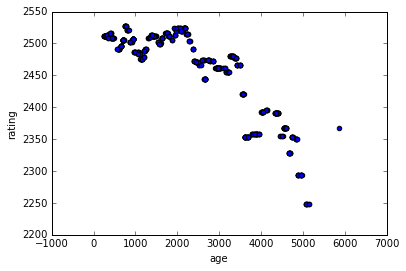

In [94]:
testdf[testdf['player']=='Harika, Dronavalli'].plot('age','rating',kind='scatter')

In [100]:
ratings = testdf.drop_duplicates()

In [112]:
ratingsA = ratings[ratings.sort('age')['player']=='Harika, Dronavalli']

/Users/eduardodaroza/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/Users/eduardodaroza/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [119]:
ratingsA= ratingsA.sort('age')

/Users/eduardodaroza/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [120]:
ratingsA['gap_events'] = ratingsA['age'] - ratingsA['age'].shift(1) 

In [137]:
ratingsA.head(5)

,player,rating,age,gap_events,ratings_delta
34,"Harika, Dronavalli",2511,262.0,1.0,NaN
933487,"Harika, Dronavalli",2511,263.0,1.0,0.0
303668,"Harika, Dronavalli",2511,264.0,1.0,0.0
456458,"Harika, Dronavalli",2511,268.0,4.0,0.0
456466,"Harika, Dronavalli",2511,269.0,1.0,0.0


In [122]:
ratingsA = ratingsA.drop(ratingsA.index[0])

In [132]:
ratingsA['ratings_delta'] = ratingsA['rating'] - ratingsA['rating'].shift(1) 

plot of ratings change vs date gaps with no apparent trends for sample size of 1.

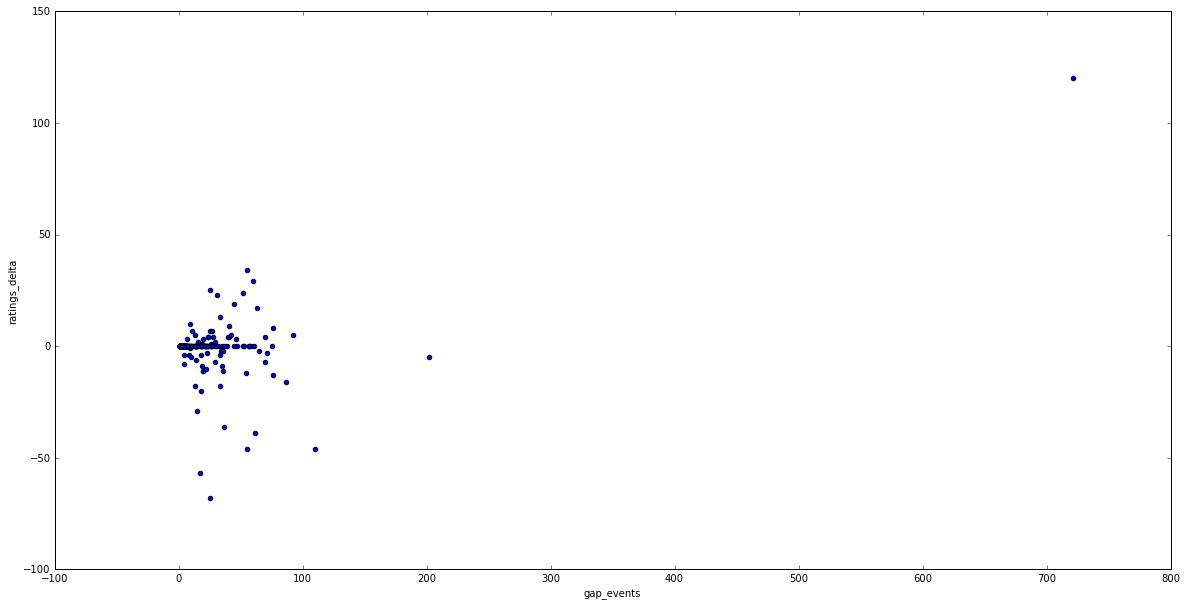

In [136]:
ratingsA.plot('gap_events','ratings_delta',kind='scatter',figsize=(20,10))

In [181]:
df.head(1)

,black,blackelo,eco,eventdate,moves,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating
0,"Kosteniuk, Alexandra",2554,A05,2016.02.28,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,0.484175


In [9]:
garbage = df.pop('eventdate')

In [10]:
df.isnull().sum()

black                             0
blackelo                          0
eco                               0
moves                             0
result                          157
white                             0
whiteelo                          0
white_first_move                  0
black_first_move                  0
age                              31
estimate_white_win_by_rating      0
dtype: int64

In [13]:
df.count()

black                           1861396
blackelo                        1861396
eco                             1861396
moves                           1861396
result                          1861396
white                           1861396
whiteelo                        1861396
white_first_move                1861396
black_first_move                1861396
age                             1861396
estimate_white_win_by_rating    1861396
dtype: int64

This next row will drop any rows that still have missing values.

In [12]:
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [14]:
df['diff'] = df['blackelo']-df['whiteelo']

In [22]:
df.groupby('white').count().sort('black',ascending=False).reset_index()['black']

/Users/eduardodaroza/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


0        1773
1        1746
2        1664
3        1529
4        1428
5        1423
6        1419
7        1374
8        1374
9        1359
10       1333
11       1326
12       1271
13       1241
14       1227
15       1214
16       1212
17       1175
18       1169
19       1169
20       1163
21       1161
22       1157
23       1144
24       1136
25       1129
26       1119
27       1118
28       1113
29       1099
         ... 
57737       1
57738       1
57739       1
57740       1
57741       1
57742       1
57743       1
57744       1
57745       1
57746       1
57747       1
57748       1
57749       1
57750       1
57751       1
57752       1
57753       1
57754       1
57755       1
57756       1
57757       1
57758       1
57759       1
57760       1
57761       1
57762       1
57763       1
57764       1
57765       1
57766       1
Name: black, dtype: int64

/Users/eduardodaroza/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,diff
0,"Aaberg, Anton",72,72,72,72,72,72,72,72,72,72,72
1,"Aabling-Thomsen, Jakob",175,175,175,175,175,175,175,175,175,175,175
2,"Aadeli, Arvin",2,2,2,2,2,2,2,2,2,2,2
3,"Aagaard, Gert",8,8,8,8,8,8,8,8,8,8,8
4,"Aagaard, Jacob",454,454,454,454,454,454,454,454,454,454,454


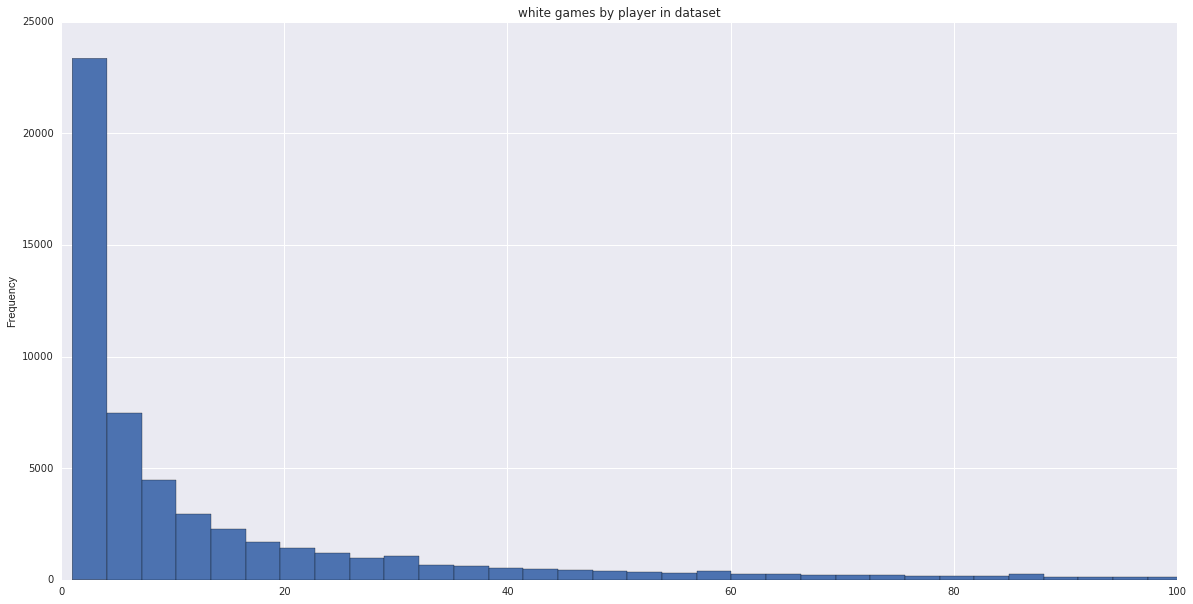

In [33]:
#some EDA:
import seaborn as sns
%matplotlib inline

df.groupby('white').count().sort('black',ascending=False)['black'].plot(kind='hist',bins=570,figsize=(20,10),xlim=(0,100),title='white games by player in dataset')

#how many times in the database by color
df.groupby('white').count().reset_index().head()
df.groupby('black').count().reset_index().head()


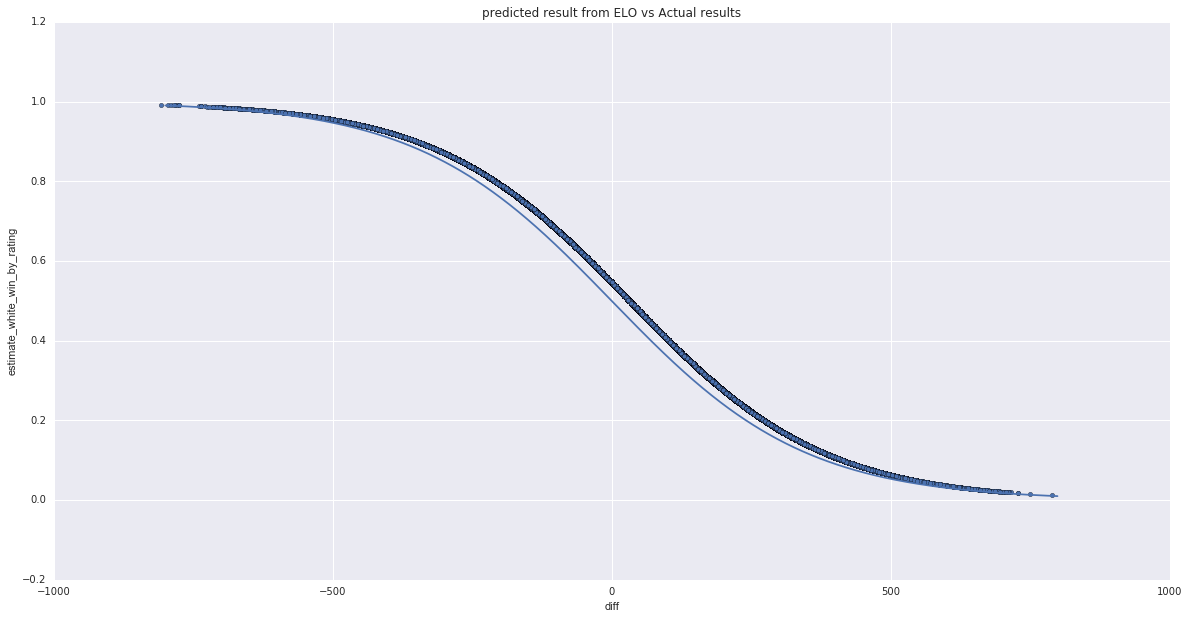

In [35]:
# elo formula vs scatter plot of the actual results by rating difference:
from math import pow 
df[['diff','estimate_white_win_by_rating']].plot(kind='scatter',x='diff',y='estimate_white_win_by_rating',figsize=(20,10),title="predicted result from ELO vs Actual results")
t = xrange(-800,800,1)
s=[]
for item in t:
    output = 1.0/(1 + pow(10.0,item/400.0))
    s.append(output)
plt.plot(t, s)


standard deviation of ratings difference:165.320504556


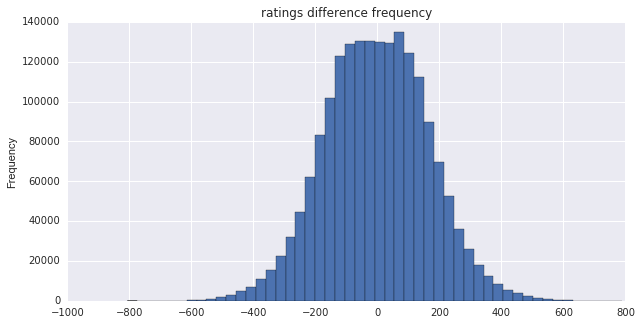

In [40]:

#avg rating difference between players is small
df['diff'].sum()/df['diff'].count()
#pairings end up being a normal distribution based on rating due to use of a swiss pairing system
df['diff'].plot(kind='hist',bins=50,title='ratings difference frequency',figsize=(10,5))
# 2 sigma is +/-330 points so one class above and below
print "standard deviation of ratings difference:{}".format(df['diff'].std())


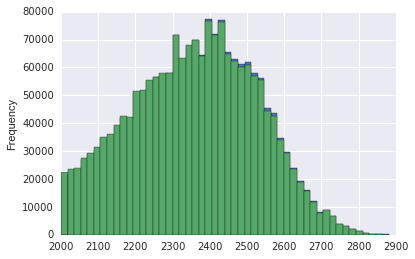

In [41]:

#ratings distribution
df.whiteelo.plot(kind='hist',bins=50)
df.blackelo.plot(kind='hist',bins=50)

#statistically different ratings?
#what are the confidence levels...can i say about similar ratings to normalize opening results?

#add number of games in the database by player...related to activity as well as time since last tournament.
#then use linear regression to predict avg rating drop between tournaments.
#count number of player by opening

#garbage = df.pop('black_first_move')
#garbage = df.pop('diff')


In [42]:
df.head(1)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,diff
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,0.484175,43


In [43]:
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [44]:
df.count()

black                           1861396
blackelo                        1861396
eco                             1861396
moves                           1861396
result                          1861396
white                           1861396
whiteelo                        1861396
white_first_move                1861396
black_first_move                1861396
age                             1861396
estimate_white_win_by_rating    1861396
diff                            1861396
dtype: int64

In [187]:
#garbage = df.pop('moves')

In [ ]:
#additional feature engineering

In [155]:
df.groupby('white')['black'].count().head()

white
Aaberg, Anton              75
Aabling-Thomsen, Jakob    163
Aadeli, Arvin               2
Aagaard, Gert               4
Aagaard, Jacob            439
Name: black, dtype: int64

In [156]:
df.groupby('black')['white'].count().head()

black
Aaberg, Anton              72
Aabling-Thomsen, Jakob    175
Aadeli, Arvin               2
Aagaard, Gert               8
Aagaard, Jacob            454
Name: white, dtype: int64

In [154]:
df.head(1)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,diff
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,0.484175,43


#considered booleanizing titled/non-titled

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1861396 entries, 0 to 1861584
Data columns (total 12 columns):
black                           category
blackelo                        int64
eco                             object
moves                           object
result                          float64
white                           category
whiteelo                        int64
white_first_move                object
black_first_move                object
age                             float64
estimate_white_win_by_rating    float64
diff                            int64
dtypes: category(2), float64(3), int64(3), object(4)
memory usage: 171.3+ MB


In [188]:
df.isnull().sum()

black                           0
blackelo                        0
eco                             0
result                          0
white                           0
whiteelo                        0
white_first_move                0
black_first_move                0
age                             0
estimate_white_win_by_rating    0
dtype: int64

In [45]:
df["white_first_move"] = df["white_first_move"].astype('string')
df["black_first_move"] = df["black_first_move"].astype('string')
df["eco"] = df["eco"].astype('string')
df["white"] = df["white"].astype('string')
df['black'] = df['black'].astype('string')

Encode white names ...can no longer use to dummy

In [47]:
catenc = pd.factorize(df['white'])

In [48]:
df['white_enc'] = catenc[0]

In [49]:
df.head(10)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,diff,white_enc
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,0.484175,43,0
1,"Ju, Wenjun",2558,A34,1.c4 c5 2.g3 Nf6 3.Bg2 d5 4.cxd5 Nxd5 5.Nc3 Nc...,-1.0,"Mkrtchian, Lilit",2434,1.c4,c5,261.0,0.370611,124,1
2,Wang Yue,2718,A18,1.c4 Nf6 2.Nc3 e6 3.e4 d5 4.e5 d4 5.exf6 dxc3 ...,-1.0,"Ivanchuk, Vassily",2710,1.c4,Nf6,261.0,0.534484,8,2
3,"Krush, Irina",2458,A25,1.c4 e5 2.Nc3 Nc6 3.g3 g6 4.Bg2 Bg7 5.e4 d6 6....,-1.0,"Mkrtchian, Lilit",2434,1.c4,e5,261.0,0.511511,24,1
4,"Paehtz, Elisabeth",2472,A26,1.Nf3 d6 2.g3 g6 3.Bg2 Bg7 4.O-O Nf6 5.d3 O-O ...,-1.0,"Huang, Qian",2450,1.Nf3,d6,261.0,0.514387,22,3
5,"Krush, Irina",2458,A07,1.Nf3 d5 2.g3 Bg4 3.Bg2 Nd7 4.c4 e6 5.cxd5 exd...,0.0,"Ju, Wenjun",2558,1.Nf3,d5,261.0,0.681322,-100,4
6,"Gunina, Valentina",2496,A11,1.Nf3 d5 2.g3 c6 3.Bg2 Bg4 4.c4 e6 5.cxd5 exd5...,1.0,Zhao Xue,2506,1.Nf3,d5,261.0,0.560150,-10,5
7,"Ushenina, A",2450,A11,1.Nf3 d5 2.g3 c6 3.c4 Nf6 4.Bg2 dxc4 5.O-O Nbd...,1.0,Tan Zhongyi,2504,1.Nf3,d5,261.0,0.621297,-54,6
8,"Lagno, Kateryna",2529,A36,1.c4 g6 2.Nc3 c5 3.g3 Bg7 4.Bg2 Nc6 5.d3 e6 6....,-1.0,"Dzagnidze, Nana",2529,1.c4,g6,261.0,0.545922,0,7
9,"Tomashevsky, E",2728,A00,1.g3 d5 2.Bg2 c6 3.d3 Nf6 4.Nd2 e5 5.e4 Bd6 6....,0.0,"Mamedov, Rauf",2650,1.g3,d5,261.0,0.434185,78,8


count number of games in dataframe for a single user

In [235]:
df[(df.black=='Kosteniuk, Alexandra')|(df.white=='Kosteniuk, Alexandra')].shape[0]

1599

In [236]:
ak_df = df[(df.black=='Kosteniuk, Alexandra')|(df.white=='Kosteniuk, Alexandra')]

In [237]:
ak_df.head()

,black,blackelo,eco,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,white_enc
0,"Kosteniuk, Alexandra",2554,A05,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,0.484175,0
56,"Kosteniuk, Alexandra",2554,A09,1.0,"Paehtz, Elisabeth",2472,1.Nf3,d5,262.0,0.428537,13
63,"Kosteniuk, Alexandra",2554,A07,0.0,"Stefanova, A",2509,1.g3,d5,262.0,0.481300,9
86,"Kosteniuk, Alexandra",2554,A05,1.0,"Stefanova, A",2509,1.Nf3,Nf6,263.0,0.481300,9
1049,"Kosteniuk, Alexandra",2550,A11,1.0,"Jakovenko, Dmitry",2732,1.Nf3,d5,293.0,0.774148,452


In [258]:
ak_df.count()

black                           1599
blackelo                        1599
eco                             1599
result                          1599
white                           1599
whiteelo                        1599
white_first_move                1599
black_first_move                1599
age                             1599
estimate_white_win_by_rating    1599
white_enc                       1599
dtype: int64

In [ ]:
#unique eco codes or variety of openings played

In [242]:
len(ak_df[ak_df.white=='Kosteniuk, Alexandra'].eco.unique())

161

In [ ]:
#unique first moves or variety of first moves played

In [243]:
len(ak_df[ak_df.white=='Kosteniuk, Alexandra'].white_first_move.unique())

4

number of players in the dataset:

In [238]:
df.white_enc.max()

57766

# this is the last section i worked on Thur 11/16 night and should be put after classes where built below

calculate the number of games played by white with same opening per player:

In [57]:
temp = df.groupby(['white','eco']).size().reset_index().rename(columns={0:'white_opening_count'})

In [59]:
temp2 = df.groupby(['black','eco']).size().reset_index().rename(columns={0:'black_opening_count'})

In [71]:
temp.head()

,white,eco,white_opening_count
0,"Aaberg, Anton",A04,1
1,"Aaberg, Anton",A05,1
2,"Aaberg, Anton",A13,1
3,"Aaberg, Anton",A21,2
4,"Aaberg, Anton",A29,1


In [111]:
df = df.join(temp.set_index(['white','eco']), on=('white','eco'))

In [89]:
testdummy = df.groupby(['white','eco'])['white'].size().reset_index()

In [102]:
testdummy[testdummy['white']=='Harika, Dronavalli'].head()

,white,eco,0
287114,"Harika, Dronavalli",A00,3
287115,"Harika, Dronavalli",A03,1
287116,"Harika, Dronavalli",A04,10
287117,"Harika, Dronavalli",A05,4
287118,"Harika, Dronavalli",A06,6


In [ ]:
verify some of the values

In [105]:
df.loc[(df['white']=='Harika, Dronavalli') & (df['eco'] == 'A05')]

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,...,white_level_Expert,white_level_GM,white_level_IM,white_level_Master,white_level_Super GM,black_level_Expert,black_level_GM,black_level_IM,black_level_Master,black_level_Super GM
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2243,"Derakhshani, Dorsa",2307,A05,1.Nf3 Nf6 2.b3 b6 3.Bb2 Bb7 4.e3 e6 5.d4 d5 6....,1.0,"Harika, Dronavalli",2513,1.Nf3,Nf6,332.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7734,"Padmini, Rout",2444,A05,1.Nf3 Nf6 2.g3 g6 3.b3 Bg7 4.Bb2 d5 5.c4 O-O 6...,0.0,"Harika, Dronavalli",2509,1.Nf3,Nf6,463.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
84954,"Gomes, Mary Ann",2384,A05,1.g3 Nf6 2.Bg2 c5 3.Nf3 Nc6 4.d4 cxd4 5.Nxd4 d...,0.0,"Harika, Dronavalli",2467,1.g3,Nf6,2518.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [108]:
df.loc[(df['white']=='Mkrtchian, Lilit') & (df['eco'] == 'A34')].shape

(5, 27)

do the same merge for black

In [112]:
df = df.join(temp2.set_index(['black','eco']), on=('black','eco'))

In [113]:
df.head(1)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,...,white_level_IM,white_level_Master,white_level_Super GM,black_level_Expert,black_level_GM,black_level_IM,black_level_Master,black_level_Super GM,white_opening_count,black_opening_count
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,5


In [117]:
df.loc[(df['black']=='Kosteniuk, Alexandra') & (df['eco'] == 'A05')].head(1)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,...,white_level_IM,white_level_Master,white_level_Super GM,black_level_Expert,black_level_GM,black_level_IM,black_level_Master,black_level_Super GM,white_opening_count,black_opening_count
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,5


In [118]:
import cPickle as pickle
#favorite_color = { "lion": "yellow", "kitty": "red" }
pickle.dump(df, open( "../data/df_final.pkl", "wb" ) )

turn white player into categorical

In [122]:
whitedf = pd.DataFrame(df.white)

lastthingtoday

this will just break

In [ ]:
#white_name = pd.get_dummies(whitedf,'white')

In [2]:
cd games

/Users/eduardodaroza/intro_dsi/capstone/Capstone/games


In [3]:
import cPickle as pickle
df = pickle.load( open( "../data/df_final.pkl", "rb" ) )

add the black enc names

In [4]:
catenc_b = pd.factorize(df['black'])
df['black_enc'] = catenc_b[0]

In [ ]:
figure out white_first_moves

In [6]:
temp_m = df.groupby(['white','white_first_move']).size().reset_index().rename(columns={0:'white_fm_count'})

In [7]:
temp2_m = df.groupby(['black','black_first_move']).size().reset_index().rename(columns={0:'black_fm_count'})

In [8]:
df = df.join(temp2_m.set_index(['black','black_first_move']), on=('black','black_first_move'))

In [9]:
df = df.join(temp_m.set_index(['white','white_first_move']), on=('white','white_first_move'))

In [10]:
df

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,...,black_level_Expert,black_level_GM,black_level_IM,black_level_Master,black_level_Super GM,white_opening_count,black_opening_count,black_enc,black_fm_count,white_fm_count
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,...,0.0,1.0,0.0,0.0,0.0,4,5,0,249,324
1,"Ju, Wenjun",2558,A34,1.c4 c5 2.g3 Nf6 3.Bg2 d5 4.cxd5 Nxd5 5.Nc3 Nc...,-1.0,"Mkrtchian, Lilit",2434,1.c4,c5,261.0,...,0.0,0.0,1.0,0.0,0.0,5,1,1,200,142
2,Wang Yue,2718,A18,1.c4 Nf6 2.Nc3 e6 3.e4 d5 4.e5 d4 5.exf6 dxc3 ...,-1.0,"Ivanchuk, Vassily",2710,1.c4,Nf6,261.0,...,0.0,0.0,0.0,0.0,1.0,4,1,2,5,195
3,"Krush, Irina",2458,A25,1.c4 e5 2.Nc3 Nc6 3.g3 g6 4.Bg2 Bg7 5.e4 d6 6....,-1.0,"Mkrtchian, Lilit",2434,1.c4,e5,261.0,...,0.0,0.0,1.0,0.0,0.0,7,8,3,45,142
4,"Paehtz, Elisabeth",2472,A26,1.Nf3 d6 2.g3 g6 3.Bg2 Bg7 4.O-O Nf6 5.d3 O-O ...,-1.0,"Huang, Qian",2450,1.Nf3,d6,261.0,...,0.0,0.0,1.0,0.0,0.0,2,4,4,69,72
5,"Krush, Irina",2458,A07,1.Nf3 d5 2.g3 Bg4 3.Bg2 Nd7 4.c4 e6 5.cxd5 exd...,0.0,"Ju, Wenjun",2558,1.Nf3,d5,261.0,...,0.0,1.0,0.0,0.0,0.0,36,11,3,193,106
6,"Gunina, Valentina",2496,A11,1.Nf3 d5 2.g3 c6 3.Bg2 Bg4 4.c4 e6 5.cxd5 exd5...,1.0,Zhao Xue,2506,1.Nf3,d5,261.0,...,0.0,1.0,0.0,0.0,0.0,1,20,5,273,13
7,"Ushenina, A",2450,A11,1.Nf3 d5 2.g3 c6 3.c4 Nf6 4.Bg2 dxc4 5.O-O Nbd...,1.0,Tan Zhongyi,2504,1.Nf3,d5,261.0,...,0.0,1.0,0.0,0.0,0.0,2,1,6,12,7
8,"Lagno, Kateryna",2529,A36,1.c4 g6 2.Nc3 c5 3.g3 Bg7 4.Bg2 Nc6 5.d3 e6 6....,-1.0,"Dzagnidze, Nana",2529,1.c4,g6,261.0,...,0.0,1.0,0.0,0.0,0.0,6,8,7,45,79
9,"Tomashevsky, E",2728,A00,1.g3 d5 2.Bg2 c6 3.d3 Nf6 4.Nd2 e5 5.e4 Bd6 6....,0.0,"Mamedov, Rauf",2650,1.g3,d5,261.0,...,0.0,1.0,0.0,0.0,0.0,20,1,8,1,29


In [13]:
df.loc[(df['black']=='Wang Yue') & (df['black_first_move'] == 'Nf6')]

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,...,black_level_Expert,black_level_GM,black_level_IM,black_level_Master,black_level_Super GM,white_opening_count,black_opening_count,black_enc,black_fm_count,white_fm_count
2,Wang Yue,2718,A18,1.c4 Nf6 2.Nc3 e6 3.e4 d5 4.e5 d4 5.exf6 dxc3 ...,-1.0,"Ivanchuk, Vassily",2710,1.c4,Nf6,261.0,...,0.0,0.0,0.0,0.0,1.0,4,1,2,5,195
74,Wang Yue,2718,A38,1.Nf3 Nf6 2.g3 g6 3.c4 Bg7 4.Nc3 c5 5.Bg2 Nc6 ...,-1.0,"Li, Chao2",2751,1.Nf3,Nf6,262.0,...,0.0,0.0,0.0,0.0,1.0,1,1,2,5,20
629376,Wang Yue,2718,D41,1.d4 Nf6 2.c4 e6 3.Nc3 d5 4.Nf3 c5 5.cxd5 cxd4...,1.0,"Mamedyarov, Shakhriyar",2747,1.d4,Nf6,261.0,...,0.0,0.0,0.0,0.0,1.0,7,1,2,5,854
1224720,Wang Yue,2718,E16,1.Nf3 Nf6 2.c4 e6 3.g3 b6 4.Bg2 Bb7 5.d4 Bb4+ ...,1.0,"Navara, David",2734,1.Nf3,Nf6,261.0,...,0.0,0.0,0.0,0.0,1.0,5,1,2,5,66
1477679,Wang Yue,2718,E36,1.d4 Nf6 2.c4 e6 3.Nc3 Bb4 4.Qc2 O-O 5.a3 Bxc3...,0.0,Wang Hao,2717,1.d4,Nf6,262.0,...,0.0,0.0,0.0,0.0,1.0,1,1,2,5,13


get overall totals and convert to percentages should just be the fraction of the two features...

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1861396 entries, 0 to 1861584
Data columns (total 32 columns):
black                           object
blackelo                        int64
eco                             object
moves                           object
result                          float64
white                           object
whiteelo                        int64
white_first_move                object
black_first_move                object
age                             float64
estimate_white_win_by_rating    float64
diff                            int64
white_enc                       int64
white_game_count                int64
black_game_count                int64
white_level                     object
black_level                     object
white_level_Expert              float64
white_level_GM                  float64
white_level_IM                  float64
white_level_Master              float64
white_level_Super GM            float64
black_level_Expert         

In [5]:
df.head()

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,...,white_level_Master,white_level_Super GM,black_level_Expert,black_level_GM,black_level_IM,black_level_Master,black_level_Super GM,white_opening_count,black_opening_count,black_enc
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,5,0
1,"Ju, Wenjun",2558,A34,1.c4 c5 2.g3 Nf6 3.Bg2 d5 4.cxd5 Nxd5 5.Nc3 Nc...,-1.0,"Mkrtchian, Lilit",2434,1.c4,c5,261.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5,1,1
2,Wang Yue,2718,A18,1.c4 Nf6 2.Nc3 e6 3.e4 d5 4.e5 d4 5.exf6 dxc3 ...,-1.0,"Ivanchuk, Vassily",2710,1.c4,Nf6,261.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,1,2
3,"Krush, Irina",2458,A25,1.c4 e5 2.Nc3 Nc6 3.g3 g6 4.Bg2 Bg7 5.e4 d6 6....,-1.0,"Mkrtchian, Lilit",2434,1.c4,e5,261.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7,8,3
4,"Paehtz, Elisabeth",2472,A26,1.Nf3 d6 2.g3 g6 3.Bg2 Bg7 4.O-O Nf6 5.d3 O-O ...,-1.0,"Huang, Qian",2450,1.Nf3,d6,261.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,4,4


In [ ]:
df['games_count']=df[(df.black=='Kosteniuk, Alexandra')|(df.white=='Kosteniuk, Alexandra')].shape[0]

In [248]:
df.groupby(['white']).count()

,black,blackelo,eco,result,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,white_enc
white,,,,,,,,,,
"Aaberg, Anton",75,75,75,75,75,75,75,75,75,75
"Aabling-Thomsen, Jakob",163,163,163,163,163,163,163,163,163,163
"Aadeli, Arvin",2,2,2,2,2,2,2,2,2,2
"Aagaard, Gert",4,4,4,4,4,4,4,4,4,4
"Aagaard, Jacob",439,439,439,439,439,439,439,439,439,439
"Aage, Bjarke",2,2,2,2,2,2,2,2,2,2
"Aakanksha, Hagawane",3,3,3,3,3,3,3,3,3,3
"Aakash, G.",3,3,3,3,3,3,3,3,3,3
"Aakio, Seppo",8,8,8,8,8,8,8,8,8,8


In [50]:
df['white_game_count'] = df.groupby('white')['white'].transform('count')

In [51]:
df['black_game_count'] = df.groupby('black')['black'].transform('count')

In [15]:
df['p_opening_given_white']=df['white_opening_count']/df['white_game_count']

In [16]:
df['p_opening_given_black']=df['black_opening_count']/df['black_game_count']

In [17]:
df['p_wfm_given_white']=df['white_fm_count']/df['white_game_count']

In [18]:
df['p_bfm_given_white']=df['black_fm_count']/df['black_game_count']

In [ ]:
done with player based FE

In [19]:
import cPickle as pickle
#favorite_color = { "lion": "yellow", "kitty": "red" }
pickle.dump(df, open( "../data/df_master.pkl", "wb" ) )

# now done so can rebuild model.  final chunk here is out of order (move fe below above)

create player groups

In [69]:
def player_level(rating):
    if rating >= 2700:
        return "Super GM"
    if rating >= 2500:
        return "GM"
    elif rating >= 2400:
        return "IM"
    elif rating >= 2200:
        return "Master"
    elif rating >= 2000:
        return "Expert"
    elif rating >= 1800:
        return "Class A"
    elif rating >= 1600:
        return "Class B"
    elif rating >= 1400:
        return "Class C"
    elif rating >= 1200:
        return "Class D"
    elif rating >= 1000:
        return "Class E"
    else:
        return "Unrated"

In [70]:
df['white_level']=df['whiteelo'].apply(player_level)

In [71]:
df['black_level']=df['blackelo'].apply(player_level)

In [72]:
df.head(10)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,diff,white_enc,white_game_count,black_game_count,white_level,black_level
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,0.484175,43,0,737,803,GM,GM
1,"Ju, Wenjun",2558,A34,1.c4 c5 2.g3 Nf6 3.Bg2 d5 4.cxd5 Nxd5 5.Nc3 Nc...,-1.0,"Mkrtchian, Lilit",2434,1.c4,c5,261.0,0.370611,124,1,494,517,IM,GM
2,Wang Yue,2718,A18,1.c4 Nf6 2.Nc3 e6 3.e4 d5 4.e5 d4 5.exf6 dxc3 ...,-1.0,"Ivanchuk, Vassily",2710,1.c4,Nf6,261.0,0.534484,8,2,1773,14,Super GM,Super GM
3,"Krush, Irina",2458,A25,1.c4 e5 2.Nc3 Nc6 3.g3 g6 4.Bg2 Bg7 5.e4 d6 6....,-1.0,"Mkrtchian, Lilit",2434,1.c4,e5,261.0,0.511511,24,1,494,717,IM,IM
4,"Paehtz, Elisabeth",2472,A26,1.Nf3 d6 2.g3 g6 3.Bg2 Bg7 4.O-O Nf6 5.d3 O-O ...,-1.0,"Huang, Qian",2450,1.Nf3,d6,261.0,0.514387,22,3,406,842,IM,IM
5,"Krush, Irina",2458,A07,1.Nf3 d5 2.g3 Bg4 3.Bg2 Nd7 4.c4 e6 5.cxd5 exd...,0.0,"Ju, Wenjun",2558,1.Nf3,d5,261.0,0.681322,-100,4,532,717,GM,IM
6,"Gunina, Valentina",2496,A11,1.Nf3 d5 2.g3 c6 3.Bg2 Bg4 4.c4 e6 5.cxd5 exd5...,1.0,Zhao Xue,2506,1.Nf3,d5,261.0,0.560150,-10,5,25,602,GM,IM
7,"Ushenina, A",2450,A11,1.Nf3 d5 2.g3 c6 3.c4 Nf6 4.Bg2 dxc4 5.O-O Nbd...,1.0,Tan Zhongyi,2504,1.Nf3,d5,261.0,0.621297,-54,6,19,14,GM,IM
8,"Lagno, Kateryna",2529,A36,1.c4 g6 2.Nc3 c5 3.g3 Bg7 4.Bg2 Nc6 5.d3 e6 6....,-1.0,"Dzagnidze, Nana",2529,1.c4,g6,261.0,0.545922,0,7,645,623,GM,GM
9,"Tomashevsky, E",2728,A00,1.g3 d5 2.Bg2 c6 3.d3 Nf6 4.Nd2 e5 5.e4 Bd6 6....,0.0,"Mamedov, Rauf",2650,1.g3,d5,261.0,0.434185,78,8,650,16,GM,Super GM


convert the levels to categorical dummies

In [74]:
import cPickle as pickle
#favorite_color = { "lion": "yellow", "kitty": "red" }
pickle.dump(df, open( "../data/df_clean.pkl", "wb" ) )

In [ ]:
Start here

In [1]:
cd games

/Users/eduardodaroza/intro_dsi/capstone/Capstone/games


In [3]:
import cPickle as pickle
df = pickle.load( open( "../data/df_clean.pkl", "rb" ) )

In [5]:
df.head(1)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,diff,white_enc,white_game_count,black_game_count,white_level,black_level
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,0.484175,43,0,737,803,GM,GM


In [7]:
test = df['white_level']

In [16]:
white_df = pd.get_dummies(test,'white_level')

In [19]:
df = pd.concat([df,white_df],axis=1)

In [21]:
test2 = df['white_level']

In [22]:
black_df = pd.get_dummies(test2,'black_level')

In [23]:
df = pd.concat([df,black_df],axis=1)

In [24]:
df

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,...,white_level_Expert,white_level_GM,white_level_IM,white_level_Master,white_level_Super GM,black_level_Expert,black_level_GM,black_level_IM,black_level_Master,black_level_Super GM
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,"Ju, Wenjun",2558,A34,1.c4 c5 2.g3 Nf6 3.Bg2 d5 4.cxd5 Nxd5 5.Nc3 Nc...,-1.0,"Mkrtchian, Lilit",2434,1.c4,c5,261.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Wang Yue,2718,A18,1.c4 Nf6 2.Nc3 e6 3.e4 d5 4.e5 d4 5.exf6 dxc3 ...,-1.0,"Ivanchuk, Vassily",2710,1.c4,Nf6,261.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,"Krush, Irina",2458,A25,1.c4 e5 2.Nc3 Nc6 3.g3 g6 4.Bg2 Bg7 5.e4 d6 6....,-1.0,"Mkrtchian, Lilit",2434,1.c4,e5,261.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,"Paehtz, Elisabeth",2472,A26,1.Nf3 d6 2.g3 g6 3.Bg2 Bg7 4.O-O Nf6 5.d3 O-O ...,-1.0,"Huang, Qian",2450,1.Nf3,d6,261.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,"Krush, Irina",2458,A07,1.Nf3 d5 2.g3 Bg4 3.Bg2 Nd7 4.c4 e6 5.cxd5 exd...,0.0,"Ju, Wenjun",2558,1.Nf3,d5,261.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,"Gunina, Valentina",2496,A11,1.Nf3 d5 2.g3 c6 3.Bg2 Bg4 4.c4 e6 5.cxd5 exd5...,1.0,Zhao Xue,2506,1.Nf3,d5,261.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,"Ushenina, A",2450,A11,1.Nf3 d5 2.g3 c6 3.c4 Nf6 4.Bg2 dxc4 5.O-O Nbd...,1.0,Tan Zhongyi,2504,1.Nf3,d5,261.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,"Lagno, Kateryna",2529,A36,1.c4 g6 2.Nc3 c5 3.g3 Bg7 4.Bg2 Nc6 5.d3 e6 6....,-1.0,"Dzagnidze, Nana",2529,1.c4,g6,261.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,"Tomashevsky, E",2728,A00,1.g3 d5 2.Bg2 c6 3.d3 Nf6 4.Nd2 e5 5.e4 Bd6 6....,0.0,"Mamedov, Rauf",2650,1.g3,d5,261.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [25]:
import cPickle as pickle
#favorite_color = { "lion": "yellow", "kitty": "red" }
pickle.dump(df, open( "../data/df_clean.pkl", "wb" ) )

In [29]:
df.moves = df.moves.astype(str)

games which started with the same first 8 moves (16 ply)

In [34]:
df.groupby('moves')['white'].count().max()

14030

# create number of times player played opening in dataset

In [40]:
df.groupby('moves')['moves'].size().mean()

2.2729832633632996

# games sharing the first 8 moves

In [48]:
df.groupby('moves')['moves'].size().max()

14030

In [52]:
df['black'].value_counts()

Van Wely, Loek                    1766
Ivanchuk, Vassily                 1744
Shirov, Alexei                    1636
Svidler, Peter                    1499
Anand, Viswanathan                1409
Tiviakov, Sergei                  1361
Gelfand, Boris                    1358
Korneev, Oleg                     1349
Epishin, Vladimir                 1338
Dreev, Aleksey                    1330
Kramnik, Vladimir                 1300
Bologan, Viktor                   1276
Lalic, Bogdan                     1223
Bacrot, Etienne                   1221
Kozul, Zdenko                     1207
Movsesian, Sergei                 1171
Burmakin, Vladimir                1161
Adams, Michael                    1160
Palac, Mladen                     1145
Leko, Peter                       1143
Grischuk, Alexander               1140
Korchnoi, Viktor                  1131
Cebalo, Miso                      1128
Krasenkow, Michal                 1126
Hebden, Mark L                    1121
Ehlvest, Jaan            

In [56]:
df[(df.black=='Kosteniuk, Alexandra')|(df.white=='Kosteniuk, Alexandra')].head(1)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,diff,white_enc,white_game_count,black_game_count
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,0.484175,43,0,737,803


total_games

In [57]:
df[(df.black=='Kosteniuk, Alexandra')]['black_game_count'].values[0]+df[(df.white=='Kosteniuk, Alexandra')]['white_game_count'].values[0]

1599

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1861396 entries, 0 to 1861584
Data columns (total 15 columns):
black                           object
blackelo                        int64
eco                             object
moves                           object
result                          float64
white                           object
whiteelo                        int64
white_first_move                object
black_first_move                object
age                             float64
estimate_white_win_by_rating    float64
diff                            int64
white_enc                       int64
white_game_count                int64
black_game_count                int64
dtypes: float64(3), int64(6), object(6)
memory usage: 227.2+ MB


how many times a player played an opening by ECO code

In [60]:
df.groupby(['white','eco']).size()
#.reset_index().groupby('eco')[[0]].max() or .groupby(level=1).max()

white                         eco
Aaberg, Anton                 A04    1
                              A05    1
                              A13    1
                              A21    2
                              A29    1
                              A37    1
                              A40    1
                              A45    3
                              A55    2
                              A56    1
                              A57    1
                              A60    1
                              A62    1
                              A63    2
                              A70    1
                              A87    1
                              A89    1
                              A93    1
                              B06    1
                              B07    1
                              B12    1
                              B15    1
                              B16    1
                              B80    2
                              

how many games in db

In [61]:
df['black'].count()

1861396

In [298]:
df.ix[df[['white','white_game_count','whiteelo']].groupby('white')['whiteelo'].idxmax()]

,black,blackelo,eco,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,white_enc,white_game_count,black_game_count
412168,"Hansen, Sune Berg",2536,A63,1.0,"Aaberg, Anton",2460,1.d4,Nf6,5415.0,0.437015,10468,75,526
598069,"Henrichs, Thomas",2476,A83,-1.0,"Aabling-Thomsen, Jakob",2375,1.d4,f5,1132.0,0.401986,875,163,285
787212,"Vaghar, Mohsen",2266,B10,1.0,"Aadeli, Arvin",2015,1.e4,c6,1586.0,0.220859,44704,2,47
325615,"Ross, David",2291,A46,1.0,"Aagaard, Gert",2067,1.d4,Nf6,1192.0,0.248759,31545,4,61
78445,"Stojanovski, Sandi",2208,A37,1.0,"Aagaard, Jacob",2542,1.c4,c5,2298.0,0.891569,12282,439,63
479592,"Mohammad Nubairshah, Shaikh",2166,D18,-1.0,"Aage, Bjarke",2067,1.d4,d5,1302.0,0.404757,38649,2,54
1313987,"Harshita, Guddanti",2181,B78,-1.0,"Aakanksha, Hagawane",2061,1.e4,c5,381.0,0.375998,54509,3,2
782644,"Lalith, Babu M R",2528,B19,-1.0,"Aakash, G.",2404,1.e4,c6,1447.0,0.370611,44464,3,438
64381,"Kosmo, Santul",2213,A04,-1.0,"Aakio, Seppo",2070,1.e4,c5,1886.0,0.345480,11095,8,133
871048,"Fernandez Garcia, Ignacio",2006,B09,1.0,"Aalbersberg Kroon, Pedro",2165,1.e4,d6,4744.0,0.750163,46349,11,23


players max rating as a function of how many games as white in the dataset

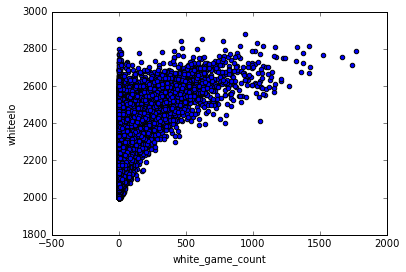

In [305]:
df.ix[df[['white','white_game_count','whiteelo']].groupby('white')['whiteelo'].idxmax()].plot('white_game_count','whiteelo',kind='scatter')

In [ ]:
plot of last updated rating as a function how many games for white 

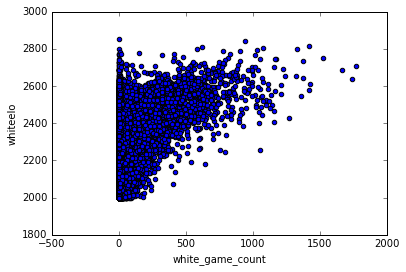

In [306]:
df.ix[df[['white','white_game_count','whiteelo','age']].groupby('white')['age'].idxmin()].plot('white_game_count','whiteelo',kind='scatter')

In [366]:
from math import log

In [ ]:
plot of last updated rating as a function how many games for black

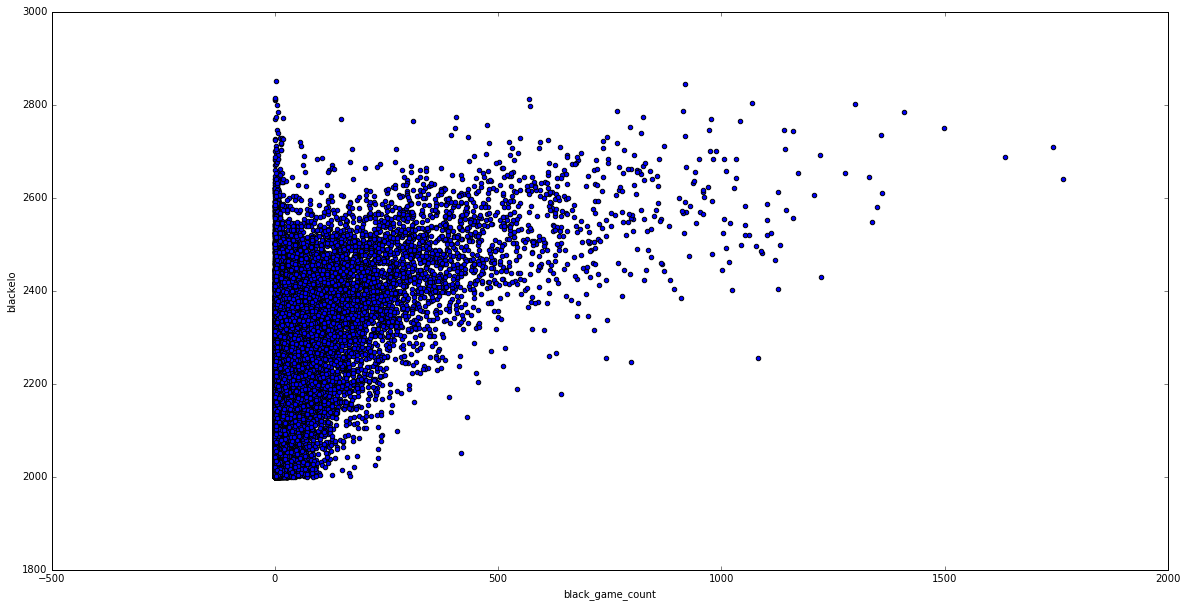

In [311]:
df.ix[df[['black','black_game_count','blackelo','age']].groupby('black')['age'].idxmin()].plot('black_game_count','blackelo',kind='scatter',figsize=(20,10))

In [58]:
from math import log10

In [59]:
rating_df = df

In [60]:
rating_df['lograting']= rating_df.whiteelo.map(log10,'whiteelo')

In [394]:
rating_df.head()

,black,blackelo,eco,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,white_enc,white_game_count,black_game_count,lograting
1785851,"Wahlstrom, Lennart",2132,C45,1.0,"Aaberg, Anton",2367,1.e4,e5,1642.0,0.823025,10468,75,18,3.374198
750696,"Gajic, Mladen",2248,B03,-1.0,"Aabling-Thomsen, Jakob",2329,1.e4,Nf6,263.0,0.657119,875,163,102,3.367169
1027098,"Nasri, Amin",2316,B40,-1.0,"Aadeli, Arvin",2015,1.e4,c5,1584.0,0.175305,44704,2,125,3.304275
467434,"Kersic, Matej",2207,D15,1.0,"Aagaard, Gert",2041,1.d4,d5,798.0,0.316184,31545,4,79,3.309843
1763382,"Ashton, Adam G",2385,C45,0.0,"Aagaard, Jacob",2498,1.e4,e5,276.0,0.697345,12282,439,208,3.397592


simple dummy model to use number of games in database to predict rating

In [310]:
rating_df = df.ix[df[['white','white_game_count','whiteelo','age']].groupby('white')['age'].idxmin()]

In [314]:
rating_df.head()

,black,blackelo,eco,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,white_enc,white_game_count,black_game_count
1785851,"Wahlstrom, Lennart",2132,C45,1.0,"Aaberg, Anton",2367,1.e4,e5,1642.0,0.823025,10468,75,18
750696,"Gajic, Mladen",2248,B03,-1.0,"Aabling-Thomsen, Jakob",2329,1.e4,Nf6,263.0,0.657119,875,163,102
1027098,"Nasri, Amin",2316,B40,-1.0,"Aadeli, Arvin",2015,1.e4,c5,1584.0,0.175305,44704,2,125
467434,"Kersic, Matej",2207,D15,1.0,"Aagaard, Gert",2041,1.d4,d5,798.0,0.316184,31545,4,79
1763382,"Ashton, Adam G",2385,C45,0.0,"Aagaard, Jacob",2498,1.e4,e5,276.0,0.697345,12282,439,208


see below for simple linear regressor to predict rating vs number games in dataset.

# this is the start of more data engineering (find player style)...look at highest most used openings and then use the style

In [111]:
style_dict = {
'Mastermind':
{'White': ['Ruy Lopez (Spanish)', "Queen's Gambit"], 
 'Black': ['Ruy Lopez (Spanish)', 'French Defense']},

'Natural':
{'White': ['Ruy Lopez (Spanish)'], 
'Black': ['Sicilian Defense',"Queen's Indian"]},

'Prodigy':
{'White': ['Ruy Lopez (Spanish)', "Queen's Gambit"],
'Black': ['Ruy Lopez (Spanish)', 'Sicilian Defense', 'Grunfeld']},

'Professional':
{'White': ['Nimzo-Indian', 'English Opening'],
'Black': ['French Defense (Winawer)', 'Sicilian Defense']},

'Romantic':
{'White': ['Ruy Lopez (Spanish)'],
'Black': ['Sicilian Defense']},

'Surgeon':
{'White': ['Ruy Lopez (Spanish)'],
'Black': ['Ruy Lopez (Spanish)', "Queen's Gambit Declined (Orthodox Defense)"]},

'Technician':
{'White': ['English Opening'],
'Black': ['Sicilian Defense','Semi-Slav', 'Petrov Defense']},

'Anaconda':
{'White': ['Four Knights', 'Reti System'],
'Black': ['French Defense','Caro-Kann']},

'Assassin':
{'White': ['Ruy Lopez (Spanish)'],
'Black': ['Sicilian Defense (Najdorf)', "King's Indian"]},

'Barbarian':
{'White': ["Queen's Gambit"],
'Black': ['Sicilian Defense']},

'Champion':
{'White': ['Ruy Lopez (Spanish)',"Queen's Gambit"],
'Black': ['Sicilian Defense']},

'Escape Artist':
{'White': ['English Opening'],
'Black': ['French Defense'] }
}


In [112]:
#then i have to translacte these word openings to their eco codes so I can count most frequent used ones.. this essentially may be done already with the probabilities

In [114]:
df.head(1)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,...,white_opening_count,black_opening_count,black_enc,black_fm_count,white_fm_count,p_opening_given_white,p_opening_given_black,p_wfm_given_white,p_bfm_given_white,lograting
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,...,4,5,0,249,324,0.005427,0.006227,0.43962,0.310087,3.399847


In [115]:
import cPickle as pickle
#favorite_color = { "lion": "yellow", "kitty": "red" }
pickle.dump(df, open( "../data/df_upload.pkl", "wb" ) )

One unanticipated challenge was creating categorical information on the player names which was a feature that had a strongest correlation to the target value of predicting opening moves.  After I transitions from shard to the total dataset of 1.8 million games, I found that the data set had over 57,000 unique player names.  Using pandas pd.get_dummies method exceed my system memory and caused my kernel to crash.  

So for the final product I will need to investigate alternative solutions such as dividing this categorical labeling into subsets and then merging them.  Alternatively, Matt suggested that I investigate using the hash trick which would hash my unique features and reduce the dimension.  One consequence of the latter option would bucket users into arbitrary groups which may have some unwanted variance to the dataset.  Yet another suggestion from Miles would be to feature engineer some groups of player styles or classes to reduce dimensionality. Lastly, I could simply reduce the number of players by only keeping those that meet a threshold of minimum number of games for example > 3 games.  This would greatly reduce the dataset and potentially allow me to use the get_dummies method on all the data. I will explore these options in greater details in week two.

4. Modeling
---
In this phase, various modeling techniques are selected and applied, and their parameters are calibrated to optimal values. Typically, there are several techniques for the same data mining problem type. Some techniques have specific requirements on the form of data. Therefore, stepping back to the data preparation phase is often needed.


The other part of modeling that I needed to consider was if the player had little or no data in the database.  The solution that I decided on after some discussion with peers and instructors was to create a seperate model that had the player names removed and use this if the user entered name was't found in the data set.  In addition I may be able to use both the player based and non-player based models in some weighted ensemble to get the desired result of using a more general model if there was only a few games in the dataset.

In [20]:
df.head(1)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,...,black_level_Super GM,white_opening_count,black_opening_count,black_enc,black_fm_count,white_fm_count,p_opening_given_white,p_opening_given_black,p_wfm_given_white,p_bfm_given_white
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,...,0.0,4,5,0,249,324,0.005427,0.006227,0.43962,0.310087


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1861396 entries, 0 to 1861584
Data columns (total 36 columns):
black                           object
blackelo                        int64
eco                             object
moves                           object
result                          float64
white                           object
whiteelo                        int64
white_first_move                object
black_first_move                object
age                             float64
estimate_white_win_by_rating    float64
diff                            int64
white_enc                       int64
white_game_count                int64
black_game_count                int64
white_level                     object
black_level                     object
white_level_Expert              float64
white_level_GM                  float64
white_level_IM                  float64
white_level_Master              float64
white_level_Super GM            float64
black_level_Expert         

In [ ]:
#need to refactor code to label player levels to remove caps and space for GM

In [91]:
#modeling
y = df['white_first_move'].values
y_eco = df['eco'].values
#X = df[['blackelo','result','whiteelo','age','estimate_white_win_by_rating']].values
##X = df[['blackelo','whiteelo','age','white_enc','result','estimate_white_win_by_rating']].values
#this takes out result so i can use NB...result didn't have much impact on prev models so will look 
#at FE with possible * with probability of white playing
X = (df[['blackelo','whiteelo','age','white_enc','black_enc','white_level_Expert',
         'white_level_GM','white_level_IM','white_level_Master','white_level_Super GM',
         'black_level_Expert','black_level_GM','black_level_IM','black_level_Master',
         'black_level_Super GM','white_opening_count','black_opening_count','black_fm_count',
         'white_fm_count', 'p_opening_given_white','p_opening_given_black','p_wfm_given_white',
         'p_bfm_given_white','estimate_white_win_by_rating']].values)
X_nouser = (df[['blackelo','whiteelo','age','white_level_Expert',
         'white_level_GM','white_level_IM','white_level_Master','white_level_Super GM',
         'black_level_Expert','black_level_GM','black_level_IM','black_level_Master',
         'black_level_Super GM','white_opening_count','black_opening_count','black_fm_count',
         'white_fm_count', 'p_opening_given_white','p_opening_given_black','p_wfm_given_white',
         'p_bfm_given_white','estimate_white_win_by_rating']].values)
#trainsplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_train_nouser, X_test_nouser, y_train_nouser, y_test_nouser = train_test_split(X_nouser, y, test_size=0.30, random_state=42)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import tree
#class_weight=
clf1 = LogisticRegression(random_state=123, multi_class='ovr')
clf2 = RandomForestClassifier(random_state=123,n_estimators=100, n_jobs=-1)
clf3 = GaussianNB()
clf4 = MultinomialNB()
clf5 = tree.DecisionTreeClassifier()

#y_pred = clf1.fit(X_train, y_train).predict(X_test)
y_pred = clf1.fit(X_train_nouser, y_train_nouser).predict(X_test_nouser)
#y_pred = clf2.fit(X_train, y_train).predict(X_test)



pickle model to use for app

In [77]:
import cPickle as pickle
pickle.dump(clf1, open( "../data/model_log.pkl", "wb" ) )

In [98]:
pickle.dump(clf1, open( "../data/model_log_nouser.pkl", "wb" ) )

In [102]:
clf1.score

<bound method LogisticRegression.score of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>

In [78]:
pickle.dump(clf2, open( "../data/model_rfc.pkl", "wb" ) )

Next to include GB model though this may suffer from high dimensionality more than random forest if I include more features.  Also, would like to explore graphlab recommender system just to see how it does vs these classifiers.

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y_eco, test_size=0.30, random_state=42)

Modeling rating

In [61]:
#modeling
#y_rating = rating_df['whiteelo'].values
y_rating = rating_df['lograting'].values
X_rating = rating_df['white_game_count']
X_rating = X_rating.reshape(-1, 1) 

%matplotlib inline
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

#use kfold to remove some variance...10 fold cross validation
#trainsplit
from sklearn.model_selection import train_test_split
X_rating_train, X_rating_test, y_rating_train, y_rating_test = train_test_split(X_rating, y_rating, test_size=0.30, random_state=42)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import tree

#poly = PolynomialFeatures(degree=2)
#X_ = poly.fit_transform(X_rating)
#predict_ = poly.fit_transform(y_rating)
#class_weight='balanced'
clf = LinearRegression()
y_rating_pred = clf.fit(X_rating_train, y_rating_train).predict(X_rating_test)




In [442]:
pow(10,clf.predict(110)[0])

2236.7687659478479

In [447]:
clf.coef_

array([ 0.00013857])

In [452]:
from sklearn.feature_selection import f_regression

In [62]:
#f_regression(X_rating,y_rating)

In [ ]:
Gradient boosted classifier

In [63]:
from sklearn.ensemble import GradientBoostingClassifier #max_features sqrt n = 5 will reduce the variance

In [ ]:
est = GradientBoostingClassifier(n_estimators=50, max_depth=4, learning_rate=0.1) #learning rate went way down with , max_features=5, subsample=0.9
est.fit(X_train, y_train)

# predict class labels
pred = est.predict(X_test)

# score on test data (accuracy)
acc = est.score(X_test, y_test)
print('ACC: %.4f' % acc)

# predict class probabilities
est.predict_proba(X_test)[0]

In [120]:
y_pred = est.predict(X_test)
clf_probs = est.predict_proba(X_test)
score = log_loss(y_test, clf_probs)
print accuracy_score(y_test, y_pred)
print score

0.57598684858502303

In [121]:
score

1.595217153240444

prior attempts

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False
63%acc on train data

In [ ]:
no user

In [84]:
est

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=4,
              max_features=5, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=0.9, verbose=0, warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=4,
              max_features=5, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=0.9, verbose=0, warm_start=False)
%.0079 accuracy was very low

XGBOOST model

In [90]:

import xgboost as xib
gbm = xib.XGBClassifier(max_depth=3,n_estimators=1,learning_rate=0.1).fit(X_train,y_train)
predictions = gym.predict(X_test)

ImportError: No module named xgboost

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
54%

5. Evaluation
---
At this stage in the project you have built a model (or models) that appears to have high quality, from a data analysis perspective. Before proceeding to final deployment of the model, it is important to more thoroughly evaluate the model, and review the steps executed to construct the model, to be certain it properly achieves the business objectives. A key objective is to determine if there is some important business issue that has not been sufficiently considered. At the end of this phase, a decision on the use of the data mining results should be reached.


Initial models failed to provide much predictive power especially when using the larger dataset without player name.  logit regression seems to provide best outof box.  

logistic regression

In [28]:
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import log_loss

clf_probs = clf1.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

In [29]:
accuracy_score(y_test, y_pred)

0.50098760966227873

In [30]:
f1_score(y_test, y_pred, average='micro') 

0.50098760966227873

In [31]:
score

1.0665213943443967

In [79]:
# acc = clf1.score(X_test, y_test)
# print('ACC: %.4f' % acc)

no use info


In [93]:
clf_probs = clf1.predict_proba(X_test_nouser)
score = log_loss(y_test_nouser, clf_probs)

In [94]:
score

1.0506690434309069

In [95]:
accuracy_score(y_test, y_pred)

0.51349434743445332

In [96]:
X_test_nouser[0]

array([  2.37000000e+03,   2.16300000e+03,   3.47400000e+03,
         1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   4.00000000e+00,   5.00000000e+00,
         1.90000000e+01,   9.20000000e+01,   4.34782609e-02,
         2.65957447e-02,   1.00000000e+00,   1.01063830e-01,
         2.67492710e-01])

In [97]:
X_test[0]

array([  2.37000000e+03,   2.16300000e+03,   3.47400000e+03,
         1.29850000e+04,   1.08010000e+04,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         4.00000000e+00,   5.00000000e+00,   1.90000000e+01,
         9.20000000e+01,   4.34782609e-02,   2.65957447e-02,
         1.00000000e+00,   1.01063830e-01,   2.67492710e-01])

rfc (100 trees)

In [49]:
clf_probs = clf2.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

In [50]:
accuracy_score(y_test, y_pred)

0.78607640499338316

In [51]:
score

0.65984409068508587

In [54]:
names=['blackelo','whiteelo','age','white_enc','black_enc','white_level_Expert',
         'white_level_GM','white_level_IM','white_level_Master','white_level_Super GM',
         'black_level_Expert','black_level_GM','black_level_IM','black_level_Master',
         'black_level_Super GM','white_opening_count','black_opening_count','black_fm_count',
         'white_fm_count', 'p_opening_given_white','p_opening_given_black','p_wfm_given_white',
         'p_bfm_given_white','estimate_white_win_by_rating']
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x,4), clf2.feature_importances_),names),reverse=True)

Features sorted by their score:
[(0.1654, 'white_enc'), (0.1506, 'p_wfm_given_white'), (0.0981, 'white_fm_count'), (0.0636, 'p_opening_given_white'), (0.0625, 'p_bfm_given_white'), (0.0606, 'age'), (0.0585, 'whiteelo'), (0.0574, 'p_opening_given_black'), (0.0557, 'black_enc'), (0.0503, 'blackelo'), (0.0498, 'estimate_white_win_by_rating'), (0.0494, 'black_fm_count'), (0.0329, 'white_opening_count'), (0.03, 'black_opening_count'), (0.0022, 'white_level_Master'), (0.0021, 'black_level_Master'), (0.0019, 'white_level_IM'), (0.0018, 'white_level_GM'), (0.0018, 'black_level_IM'), (0.0018, 'black_level_GM'), (0.0014, 'black_level_Expert'), (0.0013, 'white_level_Expert'), (0.0005, 'black_level_Super GM'), (0.0004, 'white_level_Super GM')]


the classses I created appear to have little correlation to the response variable.  it could be that they simple are represented well by the rating
which is the 7th in the list so their significance is reduced)

In [65]:
acc = clf2.score(X_test, y_test)
print('ACC: %.4f' % acc)

ACC: 0.7861


feature importances show .15 ->percentage_fm_given_white and who was playing .16

In [76]:
clf2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False)

confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
y_pred = clf2.fit(X_train, y_train).predict(X_test)
clf_probs = clf2.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

In [ ]:
score #RFC gives bad log_loss score compared to logit

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
class_names = df.white_first_move.unique()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

graph some roc curves of three different models

In [ ]:
gbc

In [75]:
#est.predict(X_test)

In [71]:
#est.predict(X_test[0])

In [116]:
y_pred = est.predict(X_test)
clf_probs = est.predict_proba(X_test)
score = log_loss(y_test, clf_probs)
accuracy_score(y_test, y_pred)

In [117]:
accuracy_score(y_test, y_pred)

0.54594847238364019

In [118]:
score

2.1664910365476251

Scoring for linear regression model to predict rating by number of games in dataset

In [443]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,explained_variance_score

In [429]:
r2_score(y_rating_test, y_rating_pred)

0.21026922530280634

better than random however far from very predictive.  could be explained by heteroskedacity of the data

In [444]:
explained_variance_score(y_rating_test, y_rating_pred)

0.21027463226810461

In [432]:
mean_squared_error(y_rating_test, y_rating_pred)

0.00057036375349863399

In [435]:
mean_absolute_error(y_rating_test, y_rating_pred)

0.019612010789729108

to create a better model would other features would need to be considered such as (years played) 

6. Deployment
---
Creation of the model is generally not the end of the project. Even if the purpose of the model is to increase knowledge of the data, the knowledge gained will need to be organized and presented in a way that is useful to the customer. Depending on the requirements, the deployment phase can be as simple as generating a report or as complex as implementing a repeatable data scoring (e.g. segment allocation) or data mining process. In many cases it will be the customer, not the data analyst, who will carry out the deployment steps. Even if the analyst deploys the model it is important for the customer to understand up front the actions which will need to be carried out in order to actually make use of the created models.

So far I created a flask app locally to run as a test.

I have a python library to show the fen positions on the website and have tested the open source chess engine to run from command line.

In [ ]:
import json
import chess.pgn

In [ ]:
df.head()

In [ ]:
testdf = pd.DataFrame(games) 

In [ ]:
6*3

In [ ]:
testdf.white = testdf.white.map(lambda x: x.rstrip('"\r'))
testdf.black = testdf.black.map(lambda x: x.rstrip('"\r'))
testdf.blackelo = testdf.blackelo.map(lambda x: x.rstrip('"\r'))
testdf.date = testdf.date.map(lambda x: x.rstrip('"\r'))
testdf.eco = testdf.eco.map(lambda x: x.rstrip('"\r'))
testdf.result = testdf.result.map(lambda x: x.rstrip('"\r'))
testdf.whiteelo = testdf.whiteelo.map(lambda x: x.rstrip('"\r'))

In [ ]:
testdf

### References/Citations